In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
# from tools.GRU_SingleStep_v10 import RNN_GRU
from tools.LSTM_SingleStep_v2 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-18 00:34:45.586323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-18 00:34:45.586749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:34:45.635848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:34:45.636218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:34:45.636442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 00:34:45.636736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

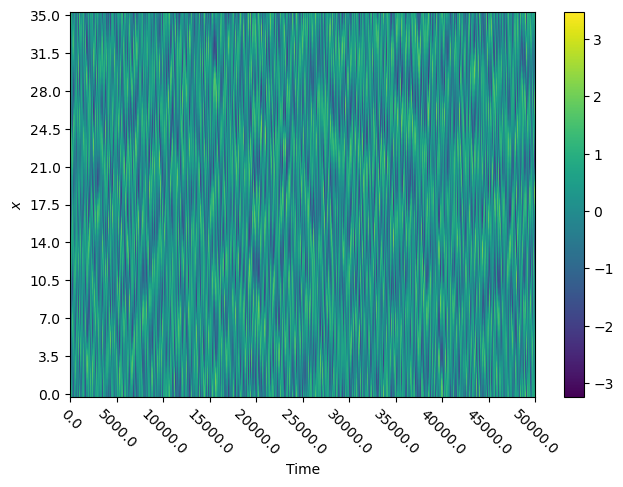

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

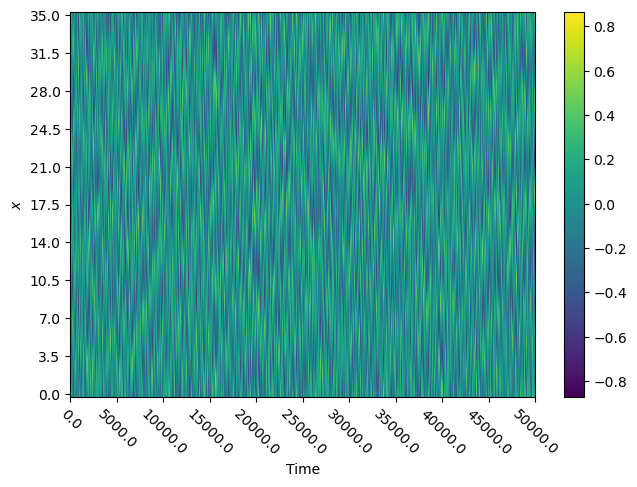

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

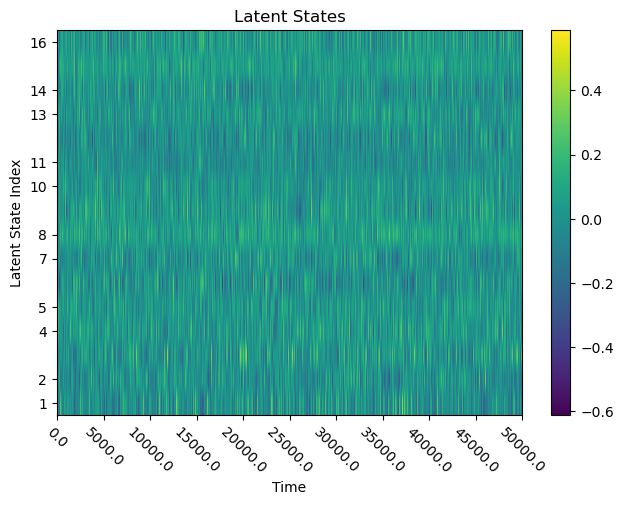

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
    use_trainable_weights_with_reslayers = True
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
        'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
    scalar_weights = None
    # scalar_weights = [
    #     0.5, 
    #     0.0, 0.5,
    #     0.0, 0.0, 1.0,
    #     1/6, 1/3, 1/3, 1/6
    # ] # RK4
    # scalar_weights = [
    #     1.0,
    #     0.25, 0.25,
    #     1/6, 1/6, 2/3
    # ] # TVD RK3
    # scalar_weights = [
    #     1.0,
    #     0.5, 0.5
    # ] # TVD RK2
    # rnn_layers_units = [500]*int(1 + ((8*len(scalar_weights)+1)**0.5 - 1)/2)
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
                use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
            use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0411 - mse: 0.0395 - NMSE: 0.3559 - tot_time: 0h 0m 20.7s

Epoch 1: val_NMSE improved from inf to 0.14018, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 21s 2s/step - loss: 0.0411 - mse: 0.0395 - NMSE: 0.3559 - val_loss: 0.0172 - val_mse: 0.0156 - val_NMSE: 0.1402
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0111 - NMSE: 0.1003 - tot_time: 0h 0m 37.7s

Epoch 2: val_NMSE improved from 0.14018 to 0.08148, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0137 - tot_time: 0h 4m 23.5s

Epoch 15: val_NMSE improved from 0.02238 to 0.02171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0137 - val_loss: 0.0038 - val_mse: 0.0024 - val_NMSE: 0.0217
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0015 - NMSE: 0.0131 - tot_time: 0h 4m 40.8s

Epoch 16: val_NMSE improved from 0.02171 to 0.02109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - lo

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 9.3424e-04 - NMSE: 0.0084 - tot_time: 0h 8m 44.7s

Epoch 30: val_NMSE improved from 0.01572 to 0.01544, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0021 - mse: 9.3424e-04 - NMSE: 0.0084 - val_loss: 0.0029 - val_mse: 0.0017 - val_NMSE: 0.0154
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 9.1047e-04 - NMSE: 0.0082 - tot_time: 0h 9m 2.1s

Epoch 31: val_NMSE improved from 0.01544 to 0.01517, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=========================

Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 6.5494e-04 - NMSE: 0.0059 - tot_time: 0h 13m 6.5s

Epoch 45: val_NMSE improved from 0.01223 to 0.01206, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0017 - mse: 6.5494e-04 - NMSE: 0.0059 - val_loss: 0.0024 - val_mse: 0.0013 - val_NMSE: 0.0121
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 6.4005e-04 - NMSE: 0.0058 - tot_time: 0h 13m 23.9s

Epoch 46: val_NMSE improved from 0.01206 to 0.01188, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=======================

Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.6828e-04 - NMSE: 0.0042 - tot_time: 0h 17m 27.3s

Epoch 60: val_NMSE improved from 0.00978 to 0.00966, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0014 - mse: 4.6828e-04 - NMSE: 0.0042 - val_loss: 0.0020 - val_mse: 0.0011 - val_NMSE: 0.0097
Epoch 61/1000
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.5953e-04 - NMSE: 0.0041 - tot_time: 0h 17m 44.5s

Epoch 61: val_NMSE improved from 0.00966 to 0.00955, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0013 - mse: 3.6121e-04 - NMSE: 0.0033 - val_loss: 0.0018 - val_mse: 9.1908e-04 - val_NMSE: 0.0083
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.5684e-04 - NMSE: 0.0032 - tot_time: 0h 21m 46.7s

Epoch 75: val_NMSE improved from 0.00827 to 0.00813, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0013 - mse: 3.5684e-04 - NMSE: 0.0032 - val_loss: 0.0018 - val_mse: 9.0344e-04 - val_NMSE: 0.0081
Epoch 76/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 3.4942e-04 - NMSE: 0.0031 - tot_time: 0h 22m 4.1s

Epoch 76: val_NM

8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 2.7745e-04 - NMSE: 0.0025 - tot_time: 0h 25m 48.9s

Epoch 89: val_NMSE improved from 0.00709 to 0.00708, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 0.0011 - mse: 2.7745e-04 - NMSE: 0.0025 - val_loss: 0.0016 - val_mse: 7.8650e-04 - val_NMSE: 0.0071
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 2.7322e-04 - NMSE: 0.0025 - tot_time: 0h 26m 6.4s

Epoch 90: val_NMSE improved from 0.00708 to 0.00701, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0010 - mse: 2.2837e-04 - NMSE: 0.0021 - val_loss: 0.0015 - val_mse: 6.9156e-04 - val_NMSE: 0.0062
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.2737e-04 - NMSE: 0.0020 - tot_time: 0h 30m 9.0s

Epoch 104: val_NMSE improved from 0.00623 to 0.00620, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0010 - mse: 2.2737e-04 - NMSE: 0.0020 - val_loss: 0.0015 - val_mse: 6.8873e-04 - val_NMSE: 0.0062
Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.2604e-04 - NMSE: 0.0020 - tot_time: 0h 30m 26.2s

Epoch 105: va

Epoch 118/1000
8/8 [==============================] - ETA: 0s - loss: 9.4894e-04 - mse: 1.8622e-04 - NMSE: 0.0017 - tot_time: 0h 34m 12.1s

Epoch 118: val_NMSE improved from 0.00563 to 0.00559, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 9.4894e-04 - mse: 1.8622e-04 - NMSE: 0.0017 - val_loss: 0.0014 - val_mse: 6.2110e-04 - val_NMSE: 0.0056
Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 9.4576e-04 - mse: 1.8595e-04 - NMSE: 0.0017 - tot_time: 0h 34m 29.4s

Epoch 119: val_NMSE improved from 0.00559 to 0.00556, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==

Epoch 133/1000
8/8 [==============================] - ETA: 0s - loss: 8.8764e-04 - mse: 1.6822e-04 - NMSE: 0.0015 - tot_time: 0h 38m 31.2s

Epoch 133: val_NMSE improved from 0.00517 to 0.00511, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 8.8764e-04 - mse: 1.6822e-04 - NMSE: 0.0015 - val_loss: 0.0013 - val_mse: 5.6737e-04 - val_NMSE: 0.0051
Epoch 134/1000
8/8 [==============================] - ETA: 0s - loss: 8.8079e-04 - mse: 1.6422e-04 - NMSE: 0.0015 - tot_time: 0h 38m 48.7s

Epoch 134: val_NMSE improved from 0.00511 to 0.00507, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==

8/8 [==============================] - ETA: 0s - loss: 8.2301e-04 - mse: 1.4342e-04 - NMSE: 0.0013 - tot_time: 0h 42m 34.3s

Epoch 147: val_NMSE improved from 0.00471 to 0.00468, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 8.2301e-04 - mse: 1.4342e-04 - NMSE: 0.0013 - val_loss: 0.0012 - val_mse: 5.2018e-04 - val_NMSE: 0.0047
Epoch 148/1000
8/8 [==============================] - ETA: 0s - loss: 8.1933e-04 - mse: 1.4257e-04 - NMSE: 0.0013 - tot_time: 0h 42m 51.6s

Epoch 148: val_NMSE improved from 0.00468 to 0.00466, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 7.7046e-04 - mse: 1.3306e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 4.8493e-04 - val_NMSE: 0.0044
Epoch 163/1000
8/8 [==============================] - ETA: 0s - loss: 7.6399e-04 - mse: 1.2938e-04 - NMSE: 0.0012 - tot_time: 0h 47m 9.5s

Epoch 163: val_NMSE improved from 0.00437 to 0.00434, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 7.6399e-04 - mse: 1.2938e-04 - NMSE: 0.0012 - val_loss: 0.0011 - val_mse: 4.8175e-04 - val_NMSE: 0.0043
Epoch 164/1000
8/8 [==============================] - ETA: 0s - loss: 7.6124e-04 - mse: 1.2941e-04 - NMSE: 0.0012 - tot_time: 0h 47m 26.9

8/8 [==============================] - ETA: 0s - loss: 7.1566e-04 - mse: 1.1970e-04 - NMSE: 0.0011 - tot_time: 0h 51m 12.0s

Epoch 177: val_NMSE improved from 0.00412 to 0.00410, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 7.1566e-04 - mse: 1.1970e-04 - NMSE: 0.0011 - val_loss: 0.0011 - val_mse: 4.5584e-04 - val_NMSE: 0.0041
Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 7.1106e-04 - mse: 1.1783e-04 - NMSE: 0.0011 - tot_time: 0h 51m 29.3s

Epoch 178: val_NMSE improved from 0.00410 to 0.00407, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=================

8/8 [==============================] - ETA: 0s - loss: 6.6479e-04 - mse: 1.0930e-04 - NMSE: 9.8384e-04 - tot_time: 0h 55m 30.3s

Epoch 192: val_NMSE improved from 0.00382 to 0.00382, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 6.6479e-04 - mse: 1.0930e-04 - NMSE: 9.8384e-04 - val_loss: 9.7786e-04 - val_mse: 4.2386e-04 - val_NMSE: 0.0038
Epoch 193/1000
8/8 [==============================] - ETA: 0s - loss: 6.6131e-04 - mse: 1.0847e-04 - NMSE: 9.7642e-04 - tot_time: 0h 55m 47.6s

Epoch 193: val_NMSE improved from 0.00382 to 0.00381, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.2209e-04 - mse: 1.0327e-04 - NMSE: 9.2962e-04 - val_loss: 9.1960e-04 - val_mse: 4.0224e-04 - val_NMSE: 0.0036
Epoch 207/1000
8/8 [==============================] - ETA: 0s - loss: 6.1862e-04 - mse: 1.0238e-04 - NMSE: 9.2157e-04 - tot_time: 0h 59m 51.7s

Epoch 207: val_NMSE improved from 0.00362 to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 6.1862e-04 - mse: 1.0238e-04 - NMSE: 9.2157e-04 - val_loss: 9.1356e-04 - val_mse: 3.9877e-04 - val_NMSE: 0.0036
Epoch 208/1000
8/8 [==============================] - ETA: 0s - loss: 6.1441e-04 - mse: 1.0074e-04 - NMSE: 9.0680e-0

8/8 [==============================] - ETA: 0s - loss: 5.7632e-04 - mse: 9.5442e-05 - NMSE: 8.5912e-04 - tot_time: 1h 3m 53.2s

Epoch 221: val_NMSE improved from 0.00341 to 0.00340, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 5.7632e-04 - mse: 9.5442e-05 - NMSE: 8.5912e-04 - val_loss: 8.5750e-04 - val_mse: 3.7802e-04 - val_NMSE: 0.0034
Epoch 222/1000
8/8 [==============================] - ETA: 0s - loss: 5.7616e-04 - mse: 9.7763e-05 - NMSE: 8.8000e-04 - tot_time: 1h 4m 10.6s

Epoch 222: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 5.7616e-04 - mse: 9.7763e-05 - NMSE: 8.8000e-04 - va

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 5.3776e-04 - mse: 9.0934e-05 - NMSE: 8.1853e-04 - val_loss: 8.0567e-04 - val_mse: 3.6019e-04 - val_NMSE: 0.0032
Epoch 236/1000
8/8 [==============================] - ETA: 0s - loss: 5.3462e-04 - mse: 9.0171e-05 - NMSE: 8.1167e-04 - tot_time: 1h 8m 12.3s

Epoch 236: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 5.3462e-04 - mse: 9.0171e-05 - NMSE: 8.1167e-04 - val_loss: 8.0520e-04 - val_mse: 3.6209e-04 - val_NMSE: 0.0033
Epoch 237/1000
8/8 [==============================] - ETA: 0s - loss: 5.3241e-04 - mse: 9.0335e-05 - NMSE: 8.1315e-04 - tot_time: 1h 8m 29.4s

Epoch 237: val_NMSE improved from 0.00324 to 0.00323, saving model to /home/r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 5.0000e-04 - mse: 8.8045e-05 - NMSE: 7.9253e-04 - val_loss: 7.5380e-04 - val_mse: 3.4312e-04 - val_NMSE: 0.0031
Epoch 251/1000
8/8 [==============================] - ETA: 0s - loss: 4.9705e-04 - mse: 8.7354e-05 - NMSE: 7.8631e-04 - tot_time: 1h 12m 32.6s

Epoch 251: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.9705e-04 - mse: 8.7354e-05 - NMSE: 7.8631e-04 - val_loss: 7.5206e-04 - val_mse: 3.4364e-04 - val_NMSE: 0.0031
Epoch 252/1000
8/8 [==============================] - ETA: 0s - loss: 4.9423e-04 - mse: 8.6790e-05 - NMSE: 7.8124e-04 - tot_time: 1h 12m 49.5s

Epoch 252: val_NMSE improved from 0.00308 to 0.00307, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 4.6044e-04 - mse: 8.1602e-05 - NMSE: 7.3454e-04 - tot_time: 1h 16m 34.6s

Epoch 265: val_NMSE improved from 0.00292 to 0.00290, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.6044e-04 - mse: 8.1602e-05 - NMSE: 7.3454e-04 - val_loss: 7.0031e-04 - val_mse: 3.2268e-04 - val_NMSE: 0.0029
Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 4.5708e-04 - mse: 8.0390e-05 - NMSE: 7.2363e-04 - tot_time: 1h 16m 51.9s

Epoch 266: val_NMSE improved from 0.00290 to 0.00289, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=

Epoch 280/1000
8/8 [==============================] - ETA: 0s - loss: 4.2144e-04 - mse: 7.3875e-05 - NMSE: 6.6498e-04 - tot_time: 1h 20m 51.9s

Epoch 280: val_NMSE improved from 0.00279 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 4.2144e-04 - mse: 7.3875e-05 - NMSE: 6.6498e-04 - val_loss: 6.5406e-04 - val_mse: 3.0765e-04 - val_NMSE: 0.0028
Epoch 281/1000
8/8 [==============================] - ETA: 0s - loss: 4.1896e-04 - mse: 7.3421e-05 - NMSE: 6.6090e-04 - tot_time: 1h 21m 9.5s

Epoch 281: val_NMSE did not improve from 0.00277
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.1896e-04 - mse: 7.3421e-05 - NMSE:

Epoch 296/1000
8/8 [==============================] - ETA: 0s - loss: 3.9421e-04 - mse: 7.8016e-05 - NMSE: 7.0226e-04 - tot_time: 1h 25m 24.3s

Epoch 296: val_NMSE did not improve from 0.00271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.9421e-04 - mse: 7.8016e-05 - NMSE: 7.0226e-04 - val_loss: 6.1967e-04 - val_mse: 3.0453e-04 - val_NMSE: 0.0027
Epoch 297/1000
8/8 [==============================] - ETA: 0s - loss: 3.9029e-04 - mse: 7.5970e-05 - NMSE: 6.8383e-04 - tot_time: 1h 25m 41.1s

Epoch 297: val_NMSE improved from 0.00271 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.9029e-04 - mse: 7.5970e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.6225e-04 - mse: 7.1692e-05 - NMSE: 6.4533e-04 - val_loss: 5.7440e-04 - val_mse: 2.8484e-04 - val_NMSE: 0.0026
Epoch 311/1000
8/8 [==============================] - ETA: 0s - loss: 3.6062e-04 - mse: 7.1832e-05 - NMSE: 6.4659e-04 - tot_time: 1h 29m 43.3s

Epoch 311: val_NMSE improved from 0.00256 to 0.00255, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.6062e-04 - mse: 7.1832e-05 - NMSE: 6.4659e-04 - val_loss: 5.7132e-04 - val_mse: 2.8353e-04 - val_NMSE: 0.0026
Epoch 312/1000
8/8 [==============================] - ETA: 0s - loss: 3.5822e-04 - mse: 7.1194e-05 - NMSE: 6.4085e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.3078e-04 - mse: 6.5859e-05 - NMSE: 5.9283e-04 - val_loss: 5.3533e-04 - val_mse: 2.7134e-04 - val_NMSE: 0.0024
Epoch 326/1000
8/8 [==============================] - ETA: 0s - loss: 3.2913e-04 - mse: 6.5852e-05 - NMSE: 5.9276e-04 - tot_time: 1h 34m 0.9s

Epoch 326: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2913e-04 - mse: 6.5852e-05 - NMSE: 5.9276e-04 - val_loss: 5.3459e-04 - val_mse: 2.7224e-04 - val_NMSE: 0.0025
Epoch 327/1000
8/8 [==============================] - ETA: 0s - loss: 3.2724e-04 - mse: 6.5600e-05 - NMSE: 5.9049e-04 - tot_time: 1h 34m 17.8s

Epoch 327: val_NMSE improved from 0.00244 to 0.00244, saving model to /home/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0544e-04 - mse: 6.5803e-05 - NMSE: 5.9232e-04 - val_loss: 5.0269e-04 - val_mse: 2.6391e-04 - val_NMSE: 0.0024
Epoch 342/1000
8/8 [==============================] - ETA: 0s - loss: 3.0320e-04 - mse: 6.5069e-05 - NMSE: 5.8572e-04 - tot_time: 1h 38m 33.8s

Epoch 342: val_NMSE improved from 0.00238 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0320e-04 - mse: 6.5069e-05 - NMSE: 5.8572e-04 - val_loss: 5.0010e-04 - val_mse: 2.6282e-04 - val_NMSE: 0.0024
Epoch 343/1000
8/8 [==============================] - ETA: 0s - loss: 3.0089e-04 - mse: 6.4259e-05 - NMSE: 5.7842e-0

Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 2.8023e-04 - mse: 6.3741e-05 - NMSE: 5.7376e-04 - tot_time: 1h 42m 50.0s

Epoch 357: val_NMSE did not improve from 0.00230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8023e-04 - mse: 6.3741e-05 - NMSE: 5.7376e-04 - val_loss: 4.7115e-04 - val_mse: 2.5546e-04 - val_NMSE: 0.0023
Epoch 358/1000
8/8 [==============================] - ETA: 0s - loss: 2.8009e-04 - mse: 6.4990e-05 - NMSE: 5.8500e-04 - tot_time: 1h 43m 7.0s

Epoch 358: val_NMSE improved from 0.00230 to 0.00230, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 2.8009e-04 - mse: 6.4990e-05 - NMSE:

Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 2.5669e-04 - mse: 6.0039e-05 - NMSE: 5.4044e-04 - tot_time: 1h 47m 9.2s

Epoch 372: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5669e-04 - mse: 6.0039e-05 - NMSE: 5.4044e-04 - val_loss: 4.4078e-04 - val_mse: 2.4485e-04 - val_NMSE: 0.0022
Epoch 373/1000
8/8 [==============================] - ETA: 0s - loss: 2.5727e-04 - mse: 6.1882e-05 - NMSE: 5.5703e-04 - tot_time: 1h 47m 26.0s

Epoch 373: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5727e-04 - mse: 6.1882e-05 - NMSE: 5.5703e-04 - val_loss: 4.4093e-04 - val_mse: 2.4627e-04 - val_NMSE: 0.0022
Epoch 374/1000
8/8 [=======

8/8 [==============================] - ETA: 0s - loss: 2.4690e-04 - mse: 5.0404e-05 - NMSE: 4.5370e-04 - tot_time: 1h 51m 25.0s

Epoch 6: val_NMSE improved from 0.00212 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4690e-04 - mse: 5.0404e-05 - NMSE: 4.5370e-04 - val_loss: 4.3150e-04 - val_mse: 2.3507e-04 - val_NMSE: 0.0021
Epoch 7/1000
8/8 [==============================] - ETA: 0s - loss: 2.4673e-04 - mse: 5.0364e-05 - NMSE: 4.5335e-04 - tot_time: 1h 51m 42.3s

Epoch 7: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4673e-04 - mse: 5.0364e-05 - NMSE: 4.5335e-04 - val_lo

Epoch 21/1000
8/8 [==============================] - ETA: 0s - loss: 2.4428e-04 - mse: 4.9810e-05 - NMSE: 4.4837e-04 - tot_time: 1h 55m 44.4s

Epoch 21: val_NMSE improved from 0.00210 to 0.00209, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4428e-04 - mse: 4.9810e-05 - NMSE: 4.4837e-04 - val_loss: 4.2691e-04 - val_mse: 2.3252e-04 - val_NMSE: 0.0021
Epoch 22/1000
8/8 [==============================] - ETA: 0s - loss: 2.4417e-04 - mse: 4.9838e-05 - NMSE: 4.4861e-04 - tot_time: 1h 56m 1.7s

Epoch 22: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4417e-04 - mse: 4.9838e-05 - NMSE: 4.4

8/8 [==============================] - ETA: 0s - loss: 2.4186e-04 - mse: 4.9508e-05 - NMSE: 4.4565e-04 - tot_time: 2h 0m 1.4s

Epoch 36: val_NMSE improved from 0.00208 to 0.00208, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4186e-04 - mse: 4.9508e-05 - NMSE: 4.4565e-04 - val_loss: 4.2289e-04 - val_mse: 2.3062e-04 - val_NMSE: 0.0021
Epoch 37/1000
8/8 [==============================] - ETA: 0s - loss: 2.4167e-04 - mse: 4.9461e-05 - NMSE: 4.4522e-04 - tot_time: 2h 0m 18.8s

Epoch 37: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4167e-04 - mse: 4.9461e-05 - NMSE: 4.4522e-04 - val_lo

Epoch 51/1000
8/8 [==============================] - ETA: 0s - loss: 2.3931e-04 - mse: 4.9160e-05 - NMSE: 4.4251e-04 - tot_time: 2h 4m 20.5s

Epoch 51: val_NMSE did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3931e-04 - mse: 4.9160e-05 - NMSE: 4.4251e-04 - val_loss: 4.1909e-04 - val_mse: 2.2902e-04 - val_NMSE: 0.0021
Epoch 52/1000
8/8 [==============================] - ETA: 0s - loss: 2.3918e-04 - mse: 4.9182e-05 - NMSE: 4.4271e-04 - tot_time: 2h 4m 37.4s

Epoch 52: val_NMSE improved from 0.00206 to 0.00206, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3918e-04 - mse: 4.9182e-05 - NMSE: 4.42

8/8 [==============================] - ETA: 0s - loss: 2.3678e-04 - mse: 4.8910e-05 - NMSE: 4.4026e-04 - tot_time: 2h 8m 38.7s

Epoch 66: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3678e-04 - mse: 4.8910e-05 - NMSE: 4.4026e-04 - val_loss: 4.1513e-04 - val_mse: 2.2735e-04 - val_NMSE: 0.0020
Epoch 67/1000
8/8 [==============================] - ETA: 0s - loss: 2.3661e-04 - mse: 4.8893e-05 - NMSE: 4.4011e-04 - tot_time: 2h 8m 55.5s

Epoch 67: val_NMSE improved from 0.00204 to 0.00204, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3661e-04 - mse: 4.8893e-05 - NMSE: 4.4011e-04 - val_l

Epoch 81/1000
8/8 [==============================] - ETA: 0s - loss: 2.3422e-04 - mse: 4.8712e-05 - NMSE: 4.3848e-04 - tot_time: 2h 12m 57.7s

Epoch 81: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3422e-04 - mse: 4.8712e-05 - NMSE: 4.3848e-04 - val_loss: 4.1142e-04 - val_mse: 2.2600e-04 - val_NMSE: 0.0020
Epoch 82/1000
8/8 [==============================] - ETA: 0s - loss: 2.3411e-04 - mse: 4.8762e-05 - NMSE: 4.3893e-04 - tot_time: 2h 13m 14.6s

Epoch 82: val_NMSE improved from 0.00203 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3411e-04 - mse: 4.8762e-05 - NMSE: 4.

Epoch 96/1000
8/8 [==============================] - ETA: 0s - loss: 2.3159e-04 - mse: 4.8525e-05 - NMSE: 4.3679e-04 - tot_time: 2h 17m 16.5s

Epoch 96: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3159e-04 - mse: 4.8525e-05 - NMSE: 4.3679e-04 - val_loss: 4.0730e-04 - val_mse: 2.2433e-04 - val_NMSE: 0.0020
Epoch 97/1000
8/8 [==============================] - ETA: 0s - loss: 2.3136e-04 - mse: 4.8460e-05 - NMSE: 4.3621e-04 - tot_time: 2h 17m 33.4s

Epoch 97: val_NMSE improved from 0.00202 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3136e-04 - mse: 4.8460e-05 - NMSE: 4.

Epoch 111/1000
8/8 [==============================] - ETA: 0s - loss: 2.2889e-04 - mse: 4.8346e-05 - NMSE: 4.3518e-04 - tot_time: 2h 21m 35.7s

Epoch 111: val_NMSE improved from 0.00201 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2889e-04 - mse: 4.8346e-05 - NMSE: 4.3518e-04 - val_loss: 4.0308e-04 - val_mse: 2.2263e-04 - val_NMSE: 0.0020
Epoch 112/1000
8/8 [==============================] - ETA: 0s - loss: 2.2871e-04 - mse: 4.8343e-05 - NMSE: 4.3516e-04 - tot_time: 2h 21m 53.2s

Epoch 112: val_NMSE improved from 0.00200 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCh

Epoch 126/1000
8/8 [==============================] - ETA: 0s - loss: 2.2612e-04 - mse: 4.8168e-05 - NMSE: 4.3358e-04 - tot_time: 2h 25m 55.2s

Epoch 126: val_NMSE improved from 0.00199 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2612e-04 - mse: 4.8168e-05 - NMSE: 4.3358e-04 - val_loss: 3.9914e-04 - val_mse: 2.2128e-04 - val_NMSE: 0.0020
Epoch 127/1000
8/8 [==============================] - ETA: 0s - loss: 2.2601e-04 - mse: 4.8232e-05 - NMSE: 4.3415e-04 - tot_time: 2h 26m 12.5s

Epoch 127: val_NMSE improved from 0.00199 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCh

Epoch 141/1000
8/8 [==============================] - ETA: 0s - loss: 2.2325e-04 - mse: 4.7962e-05 - NMSE: 4.3173e-04 - tot_time: 2h 30m 14.0s

Epoch 141: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2325e-04 - mse: 4.7962e-05 - NMSE: 4.3173e-04 - val_loss: 3.9515e-04 - val_mse: 2.1996e-04 - val_NMSE: 0.0020
Epoch 142/1000
8/8 [==============================] - ETA: 0s - loss: 2.2300e-04 - mse: 4.7897e-05 - NMSE: 4.3114e-04 - tot_time: 2h 30m 31.0s

Epoch 142: val_NMSE improved from 0.00198 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2300e-04 - mse: 4.7897e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2012e-04 - mse: 4.7567e-05 - NMSE: 4.2817e-04 - val_loss: 3.9081e-04 - val_mse: 2.1836e-04 - val_NMSE: 0.0020
Epoch 157/1000
8/8 [==============================] - ETA: 0s - loss: 2.1997e-04 - mse: 4.7595e-05 - NMSE: 4.2843e-04 - tot_time: 2h 34m 47.7s

Epoch 157: val_NMSE improved from 0.00197 to 0.00196, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1997e-04 - mse: 4.7595e-05 - NMSE: 4.2843e-04 - val_loss: 3.9020e-04 - val_mse: 2.1793e-04 - val_NMSE: 0.0020
Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 2.1977e-04 - mse: 4.7580e-05 - NMSE: 4.2829e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1718e-04 - mse: 4.7415e-05 - NMSE: 4.2680e-04 - val_loss: 3.8642e-04 - val_mse: 2.1677e-04 - val_NMSE: 0.0020
Epoch 172/1000
8/8 [==============================] - ETA: 0s - loss: 2.1695e-04 - mse: 4.7377e-05 - NMSE: 4.2646e-04 - tot_time: 2h 39m 6.5s

Epoch 172: val_NMSE improved from 0.00195 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1695e-04 - mse: 4.7377e-05 - NMSE: 4.2646e-04 - val_loss: 3.8608e-04 - val_mse: 2.1661e-04 - val_NMSE: 0.0019
Epoch 173/1000
8/8 [==============================] - ETA: 0s - loss: 2.1674e-04 - mse: 4.7354e-05 - NMSE: 4.2626e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 2.1404e-04 - mse: 4.7126e-05 - NMSE: 4.2420e-04 - val_loss: 3.8186e-04 - val_mse: 2.1506e-04 - val_NMSE: 0.0019
Epoch 187/1000
8/8 [==============================] - ETA: 0s - loss: 2.1380e-04 - mse: 4.7078e-05 - NMSE: 4.2377e-04 - tot_time: 2h 43m 25.3s

Epoch 187: val_NMSE improved from 0.00194 to 0.00193, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1380e-04 - mse: 4.7078e-05 - NMSE: 4.2377e-04 - val_loss: 3.8151e-04 - val_mse: 2.1490e-04 - val_NMSE: 0.0019
Epoch 188/1000
8/8 [==============================] - ETA: 0s - loss: 2.1365e-04 - mse: 4.7120e-05 - NMSE: 4.2414e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1088e-04 - mse: 4.6879e-05 - NMSE: 4.2197e-04 - val_loss: 3.7750e-04 - val_mse: 2.1360e-04 - val_NMSE: 0.0019
Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 2.1053e-04 - mse: 4.6724e-05 - NMSE: 4.2058e-04 - tot_time: 2h 47m 42.6s

Epoch 202: val_NMSE improved from 0.00192 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1053e-04 - mse: 4.6724e-05 - NMSE: 4.2058e-04 - val_loss: 3.7709e-04 - val_mse: 2.1339e-04 - val_NMSE: 0.0019
Epoch 203/1000
8/8 [==============================] - ETA: 0s - loss: 2.1038e-04 - mse: 4.6767e-05 - NMSE: 4.2097e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0759e-04 - mse: 4.6539e-05 - NMSE: 4.1892e-04 - val_loss: 3.7297e-04 - val_mse: 2.1203e-04 - val_NMSE: 0.0019
Epoch 217/1000
8/8 [==============================] - ETA: 0s - loss: 2.0742e-04 - mse: 4.6571e-05 - NMSE: 4.1920e-04 - tot_time: 2h 52m 1.6s

Epoch 217: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0742e-04 - mse: 4.6571e-05 - NMSE: 4.1920e-04 - val_loss: 3.7267e-04 - val_mse: 2.1193e-04 - val_NMSE: 0.0019
Epoch 218/1000
8/8 [==============================] - ETA: 0s - loss: 2.0724e-04 - mse: 4.6588e-05 - NMSE: 4.1936e-04 - tot_time: 2h 52m 18.5s

Epoch 218: val_NMSE improved from 0.00191 to 0.00191, saving model to /home/

Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 2.0437e-04 - mse: 4.6317e-05 - NMSE: 4.1692e-04 - tot_time: 2h 56m 3.8s

Epoch 231: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0437e-04 - mse: 4.6317e-05 - NMSE: 4.1692e-04 - val_loss: 3.6846e-04 - val_mse: 2.1052e-04 - val_NMSE: 0.0019
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 2.0418e-04 - mse: 4.6329e-05 - NMSE: 4.1703e-04 - tot_time: 2h 56m 20.6s

Epoch 232: val_NMSE improved from 0.00189 to 0.00189, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0418e-04 - mse: 4.6329e-05 - NMSE:

Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 2.0113e-04 - mse: 4.6113e-05 - NMSE: 4.1508e-04 - tot_time: 3h 0m 21.7s

Epoch 246: val_NMSE did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0113e-04 - mse: 4.6113e-05 - NMSE: 4.1508e-04 - val_loss: 3.6398e-04 - val_mse: 2.0908e-04 - val_NMSE: 0.0019
Epoch 247/1000
8/8 [==============================] - ETA: 0s - loss: 2.0088e-04 - mse: 4.6073e-05 - NMSE: 4.1472e-04 - tot_time: 3h 0m 38.7s

Epoch 247: val_NMSE improved from 0.00188 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 2.0088e-04 - mse: 4.6073e-05 - NMSE: 

Epoch 261/1000
8/8 [==============================] - ETA: 0s - loss: 1.9777e-04 - mse: 4.5822e-05 - NMSE: 4.1246e-04 - tot_time: 3h 4m 40.9s

Epoch 261: val_NMSE improved from 0.00187 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9777e-04 - mse: 4.5822e-05 - NMSE: 4.1246e-04 - val_loss: 3.5919e-04 - val_mse: 2.0736e-04 - val_NMSE: 0.0019
Epoch 262/1000
8/8 [==============================] - ETA: 0s - loss: 1.9758e-04 - mse: 4.5843e-05 - NMSE: 4.1266e-04 - tot_time: 3h 4m 58.4s

Epoch 262: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9758e-04 - mse: 4.5843e-05 - NMSE: 

Epoch 276/1000
8/8 [==============================] - ETA: 0s - loss: 1.9447e-04 - mse: 4.5613e-05 - NMSE: 4.1059e-04 - tot_time: 3h 8m 59.3s

Epoch 276: val_NMSE did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9447e-04 - mse: 4.5613e-05 - NMSE: 4.1059e-04 - val_loss: 3.5479e-04 - val_mse: 2.0605e-04 - val_NMSE: 0.0019
Epoch 277/1000
8/8 [==============================] - ETA: 0s - loss: 1.9429e-04 - mse: 4.5645e-05 - NMSE: 4.1087e-04 - tot_time: 3h 9m 16.1s

Epoch 277: val_NMSE improved from 0.00185 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.9429e-04 - mse: 4.5645e-05 - NMSE: 

Epoch 291/1000
8/8 [==============================] - ETA: 0s - loss: 1.9115e-04 - mse: 4.5399e-05 - NMSE: 4.0865e-04 - tot_time: 3h 13m 17.4s

Epoch 291: val_NMSE improved from 0.00184 to 0.00184, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9115e-04 - mse: 4.5399e-05 - NMSE: 4.0865e-04 - val_loss: 3.5005e-04 - val_mse: 2.0443e-04 - val_NMSE: 0.0018
Epoch 292/1000
8/8 [==============================] - ETA: 0s - loss: 1.9096e-04 - mse: 4.5423e-05 - NMSE: 4.0887e-04 - tot_time: 3h 13m 34.8s

Epoch 292: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9096e-04 - mse: 4.5423e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8803e-04 - mse: 4.5192e-05 - NMSE: 4.0679e-04 - val_loss: 3.4587e-04 - val_mse: 2.0315e-04 - val_NMSE: 0.0018
Epoch 306/1000
8/8 [==============================] - ETA: 0s - loss: 1.8786e-04 - mse: 4.5229e-05 - NMSE: 4.0712e-04 - tot_time: 3h 17m 37.3s

Epoch 306: val_NMSE improved from 0.00183 to 0.00183, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8786e-04 - mse: 4.5229e-05 - NMSE: 4.0712e-04 - val_loss: 3.4548e-04 - val_mse: 2.0297e-04 - val_NMSE: 0.0018
Epoch 307/1000
8/8 [==============================] - ETA: 0s - loss: 1.8762e-04 - mse: 4.5201e-05 - NMSE: 4.0687e-0

Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 1.8454e-04 - mse: 4.5026e-05 - NMSE: 4.0530e-04 - tot_time: 3h 21m 54.1s

Epoch 321: val_NMSE improved from 0.00182 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8454e-04 - mse: 4.5026e-05 - NMSE: 4.0530e-04 - val_loss: 3.4109e-04 - val_mse: 2.0169e-04 - val_NMSE: 0.0018
Epoch 322/1000
8/8 [==============================] - ETA: 0s - loss: 1.8431e-04 - mse: 4.4996e-05 - NMSE: 4.0503e-04 - tot_time: 3h 22m 11.5s

Epoch 322: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8431e-04 - mse: 4.4996e-05 - NMSE

Epoch 336/1000
8/8 [==============================] - ETA: 0s - loss: 1.8112e-04 - mse: 4.4708e-05 - NMSE: 4.0244e-04 - tot_time: 3h 26m 13.1s

Epoch 336: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8112e-04 - mse: 4.4708e-05 - NMSE: 4.0244e-04 - val_loss: 3.3710e-04 - val_mse: 2.0080e-04 - val_NMSE: 0.0018
Epoch 337/1000
8/8 [==============================] - ETA: 0s - loss: 1.8101e-04 - mse: 4.4799e-05 - NMSE: 4.0326e-04 - tot_time: 3h 26m 30.1s

Epoch 337: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.8101e-04 - mse: 4.4799e-05 - NMSE: 4.0326e-04 - val_loss: 3.3682e-04 - val_mse: 2.0073e-04 - val_NMSE: 0.0018
Epoch 338/1000
8/8 [======

Epoch 352/1000
8/8 [==============================] - ETA: 0s - loss: 1.7767e-04 - mse: 4.4541e-05 - NMSE: 4.0094e-04 - tot_time: 3h 30m 46.8s

Epoch 352: val_NMSE improved from 0.00180 to 0.00180, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.7767e-04 - mse: 4.4541e-05 - NMSE: 4.0094e-04 - val_loss: 3.3258e-04 - val_mse: 1.9957e-04 - val_NMSE: 0.0018
Epoch 353/1000
8/8 [==============================] - ETA: 0s - loss: 1.7741e-04 - mse: 4.4487e-05 - NMSE: 4.0044e-04 - tot_time: 3h 31m 4.1s

Epoch 353: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.7741e-04 - mse: 4.4487e-05 - NMSE:

8/8 [==============================] - ETA: 0s - loss: 1.7448e-04 - mse: 4.4408e-05 - NMSE: 3.9973e-04 - tot_time: 3h 35m 4.4s

Epoch 367: val_NMSE improved from 0.00178 to 0.00178, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.7448e-04 - mse: 4.4408e-05 - NMSE: 3.9973e-04 - val_loss: 3.2812e-04 - val_mse: 1.9816e-04 - val_NMSE: 0.0018
Epoch 368/1000
8/8 [==============================] - ETA: 0s - loss: 1.7427e-04 - mse: 4.4396e-05 - NMSE: 3.9963e-04 - tot_time: 3h 35m 22.4s

Epoch 368: val_NMSE did not improve from 0.00178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.7427e-04 - mse: 4.4396e-05 - NMSE: 3.9963e-04 - v

Epoch 382/1000
8/8 [==============================] - ETA: 0s - loss: 1.7114e-04 - mse: 4.4086e-05 - NMSE: 3.9684e-04 - tot_time: 3h 39m 23.5s

Epoch 382: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.7114e-04 - mse: 4.4086e-05 - NMSE: 3.9684e-04 - val_loss: 3.2415e-04 - val_mse: 1.9721e-04 - val_NMSE: 0.0018
Epoch 383/1000
8/8 [==============================] - ETA: 0s - loss: 1.7100e-04 - mse: 4.4146e-05 - NMSE: 3.9738e-04 - tot_time: 3h 39m 40.3s

Epoch 383: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.7100e-04 - mse: 4.4146e-05 - NMSE: 3.9738e-04 - val_loss: 3.2403e-04 - val_mse: 1.9728e-04 - val_NMSE: 0.0018
Epoch 384/1000
8/8 [======

Epoch 398/1000
8/8 [==============================] - ETA: 0s - loss: 1.6777e-04 - mse: 4.3887e-05 - NMSE: 3.9505e-04 - tot_time: 3h 43m 56.7s

Epoch 398: val_NMSE improved from 0.00177 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.6777e-04 - mse: 4.3887e-05 - NMSE: 3.9505e-04 - val_loss: 3.1968e-04 - val_mse: 1.9591e-04 - val_NMSE: 0.0018
Epoch 399/1000
8/8 [==============================] - ETA: 0s - loss: 1.6761e-04 - mse: 4.3922e-05 - NMSE: 3.9536e-04 - tot_time: 3h 44m 14.0s

Epoch 399: val_NMSE improved from 0.00176 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCh

Epoch 413/1000
8/8 [==============================] - ETA: 0s - loss: 1.6460e-04 - mse: 4.3642e-05 - NMSE: 3.9284e-04 - tot_time: 3h 48m 15.6s

Epoch 413: val_NMSE improved from 0.00175 to 0.00175, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.6460e-04 - mse: 4.3642e-05 - NMSE: 3.9284e-04 - val_loss: 3.1545e-04 - val_mse: 1.9460e-04 - val_NMSE: 0.0018
Epoch 414/1000
8/8 [==============================] - ETA: 0s - loss: 1.6438e-04 - mse: 4.3611e-05 - NMSE: 3.9256e-04 - tot_time: 3h 48m 33.2s

Epoch 414: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.6438e-04 - mse: 4.3611e-05 - NMSE

8/8 [==============================] - ETA: 0s - loss: 1.6139e-04 - mse: 4.3301e-05 - NMSE: 3.8977e-04 - tot_time: 3h 52m 35.1s

Epoch 428: val_NMSE improved from 0.00174 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.6139e-04 - mse: 4.3301e-05 - NMSE: 3.8977e-04 - val_loss: 3.1154e-04 - val_mse: 1.9356e-04 - val_NMSE: 0.0017
Epoch 429/1000
8/8 [==============================] - ETA: 0s - loss: 1.6127e-04 - mse: 4.3367e-05 - NMSE: 3.9036e-04 - tot_time: 3h 52m 52.7s

Epoch 429: val_NMSE improved from 0.00174 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [=

8/8 [==============================] - ETA: 0s - loss: 1.5835e-04 - mse: 4.3079e-05 - NMSE: 3.8778e-04 - tot_time: 3h 56m 56.7s

Epoch 443: val_NMSE improved from 0.00173 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.5835e-04 - mse: 4.3079e-05 - NMSE: 3.8778e-04 - val_loss: 3.0754e-04 - val_mse: 1.9238e-04 - val_NMSE: 0.0017
Epoch 444/1000
8/8 [==============================] - ETA: 0s - loss: 1.5815e-04 - mse: 4.3067e-05 - NMSE: 3.8766e-04 - tot_time: 3h 57m 14.4s

Epoch 444: val_NMSE did not improve from 0.00173
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.5815e-04 - mse: 4.3067e-05 - NMSE: 3.8766e-04 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.5557e-04 - mse: 4.3062e-05 - NMSE: 3.8762e-04 - val_loss: 3.0405e-04 - val_mse: 1.9164e-04 - val_NMSE: 0.0017
Epoch 459/1000
8/8 [==============================] - ETA: 0s - loss: 1.5528e-04 - mse: 4.2946e-05 - NMSE: 3.8657e-04 - tot_time: 4h 1m 36.2s

Epoch 459: val_NMSE improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.5528e-04 - mse: 4.2946e-05 - NMSE: 3.8657e-04 - val_loss: 3.0361e-04 - val_mse: 1.9138e-04 - val_NMSE: 0.0017
Epoch 460/1000
8/8 [==============================] - ETA: 0s - loss: 1.5505e-04 - mse: 4.2903e-05 - NMSE: 3.8619e-04

Epoch 474/1000
8/8 [==============================] - ETA: 0s - loss: 1.5242e-04 - mse: 4.2778e-05 - NMSE: 3.8506e-04 - tot_time: 4h 5m 57.5s

Epoch 474: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.5242e-04 - mse: 4.2778e-05 - NMSE: 3.8506e-04 - val_loss: 2.9987e-04 - val_mse: 1.9033e-04 - val_NMSE: 0.0017
Epoch 475/1000
8/8 [==============================] - ETA: 0s - loss: 1.5224e-04 - mse: 4.2773e-05 - NMSE: 3.8502e-04 - tot_time: 4h 6m 15.2s

Epoch 475: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesChec

Epoch 489/1000
8/8 [==============================] - ETA: 0s - loss: 1.4961e-04 - mse: 4.2583e-05 - NMSE: 3.8331e-04 - tot_time: 4h 10m 19.6s

Epoch 489: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.4961e-04 - mse: 4.2583e-05 - NMSE: 3.8331e-04 - val_loss: 2.9624e-04 - val_mse: 1.8931e-04 - val_NMSE: 0.0017
Epoch 490/1000
8/8 [==============================] - ETA: 0s - loss: 1.4937e-04 - mse: 4.2515e-05 - NMSE: 3.8270e-04 - tot_time: 4h 10m 37.3s

Epoch 490: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.4937e-04 - mse: 4.2515e-05 - NMSE

Epoch 505/1000
8/8 [==============================] - ETA: 0s - loss: 1.4688e-04 - mse: 4.2552e-05 - NMSE: 3.8303e-04 - tot_time: 4h 14m 57.8s

Epoch 505: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.4688e-04 - mse: 4.2552e-05 - NMSE: 3.8303e-04 - val_loss: 2.9293e-04 - val_mse: 1.8870e-04 - val_NMSE: 0.0017
Epoch 506/1000
8/8 [==============================] - ETA: 0s - loss: 1.4674e-04 - mse: 4.2574e-05 - NMSE: 3.8323e-04 - tot_time: 4h 15m 15.5s

Epoch 506: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCh

Epoch 520: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 1.4576e-04 - mse: 4.2357e-05 - NMSE: 3.8128e-04 - tot_time: 4h 19m 35.0s

Epoch 1: val_NMSE improved from 0.00169 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 1.4576e-04 - mse: 4.2357e-05 - NMSE: 3.8128e-04 - val_loss: 2.9142e-04 - val_mse: 1.8803e-04 - val_NMSE: 0.0017
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 1.4498e-04 - mse: 4.1592e-05 - NMSE: 3.7439e-04 - tot_time: 4h 19m 53.2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.4441e-04 - mse: 4.1264e-05 - NMSE: 3.7143e-04 - val_loss: 2.9032e-04 - val_mse: 1.8718e-04 - val_NMSE: 0.0017
Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 1.4433e-04 - mse: 4.1197e-05 - NMSE: 3.7083e-04 - tot_time: 4h 24m 13.0s

Epoch 17: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.4433e-04 - mse: 4.1197e-05 - NMSE: 3.7083e-04 - val_loss: 2.9014e-04 - val_mse: 1.8702e-04 - val_NMSE: 0.0017
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 1.4433e-04 - mse: 4.1212e-05 - NMSE: 3.7097e-04 - tot_time: 4h 24m 30.2s

Epoch 18: val_NMSE improved from 0.00168 to 0.00168, saving model to /home/rka

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


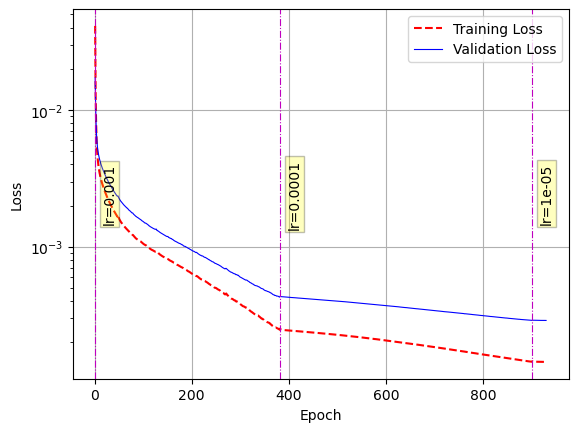

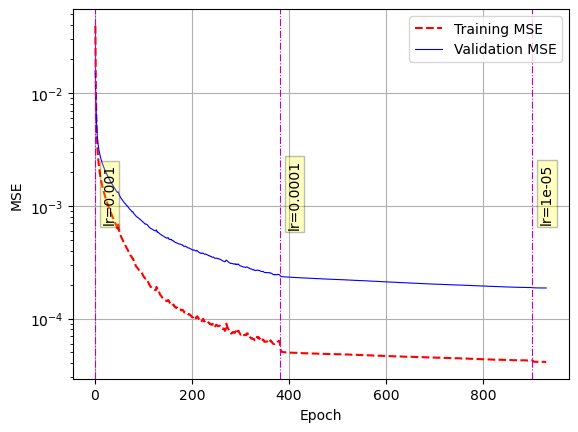

<Figure size 640x480 with 0 Axes>

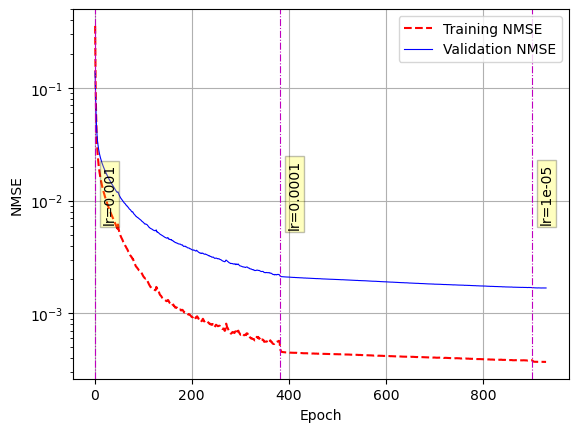

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


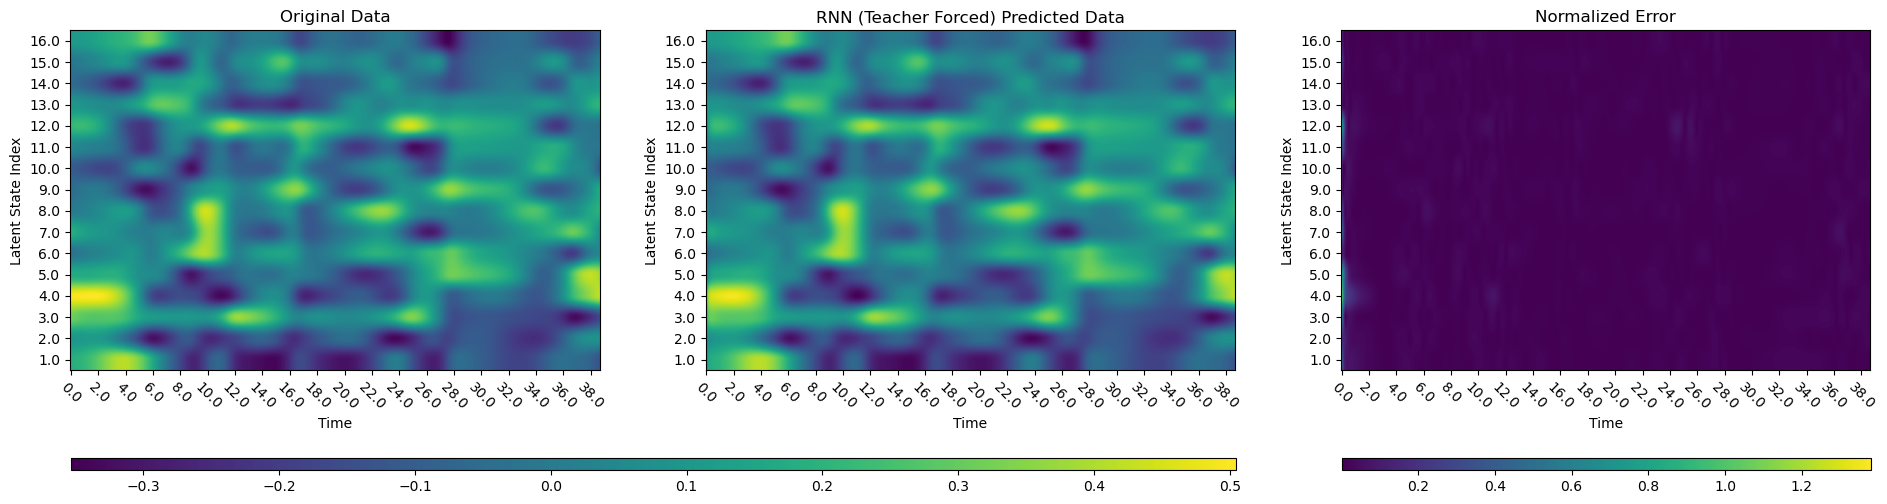

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


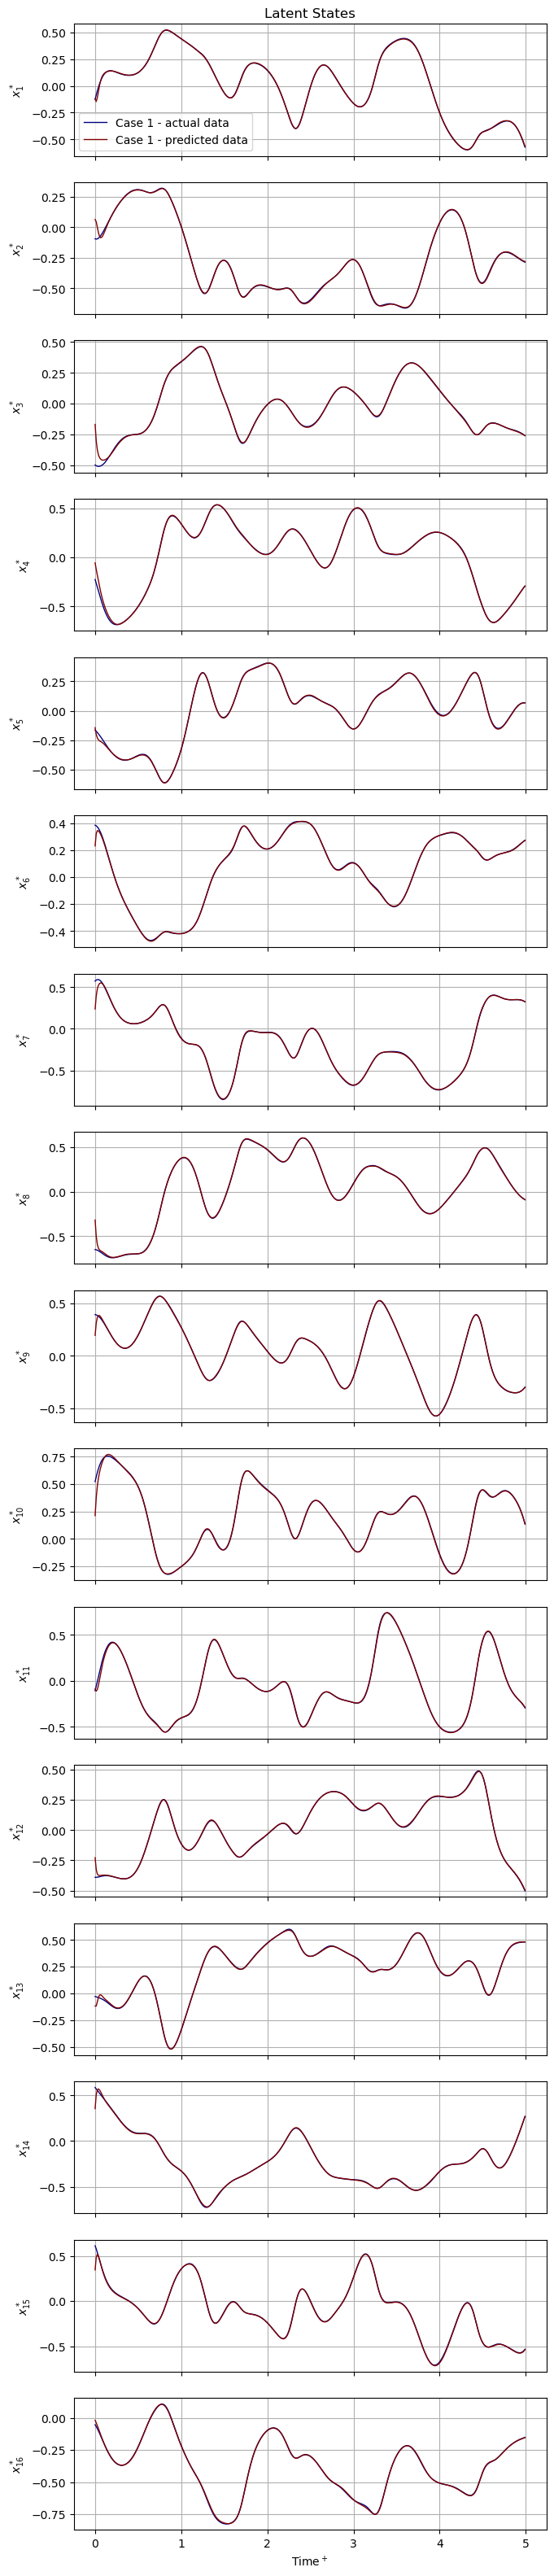


0.0


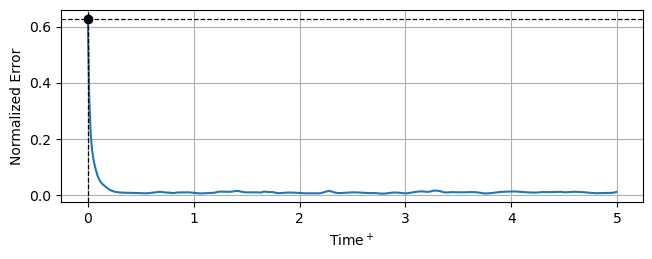

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 16)


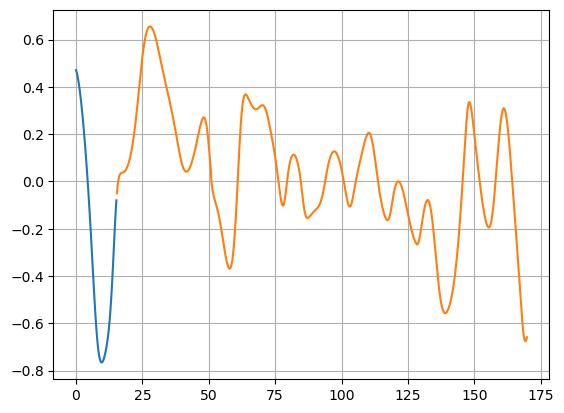

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

1.4741727871807355


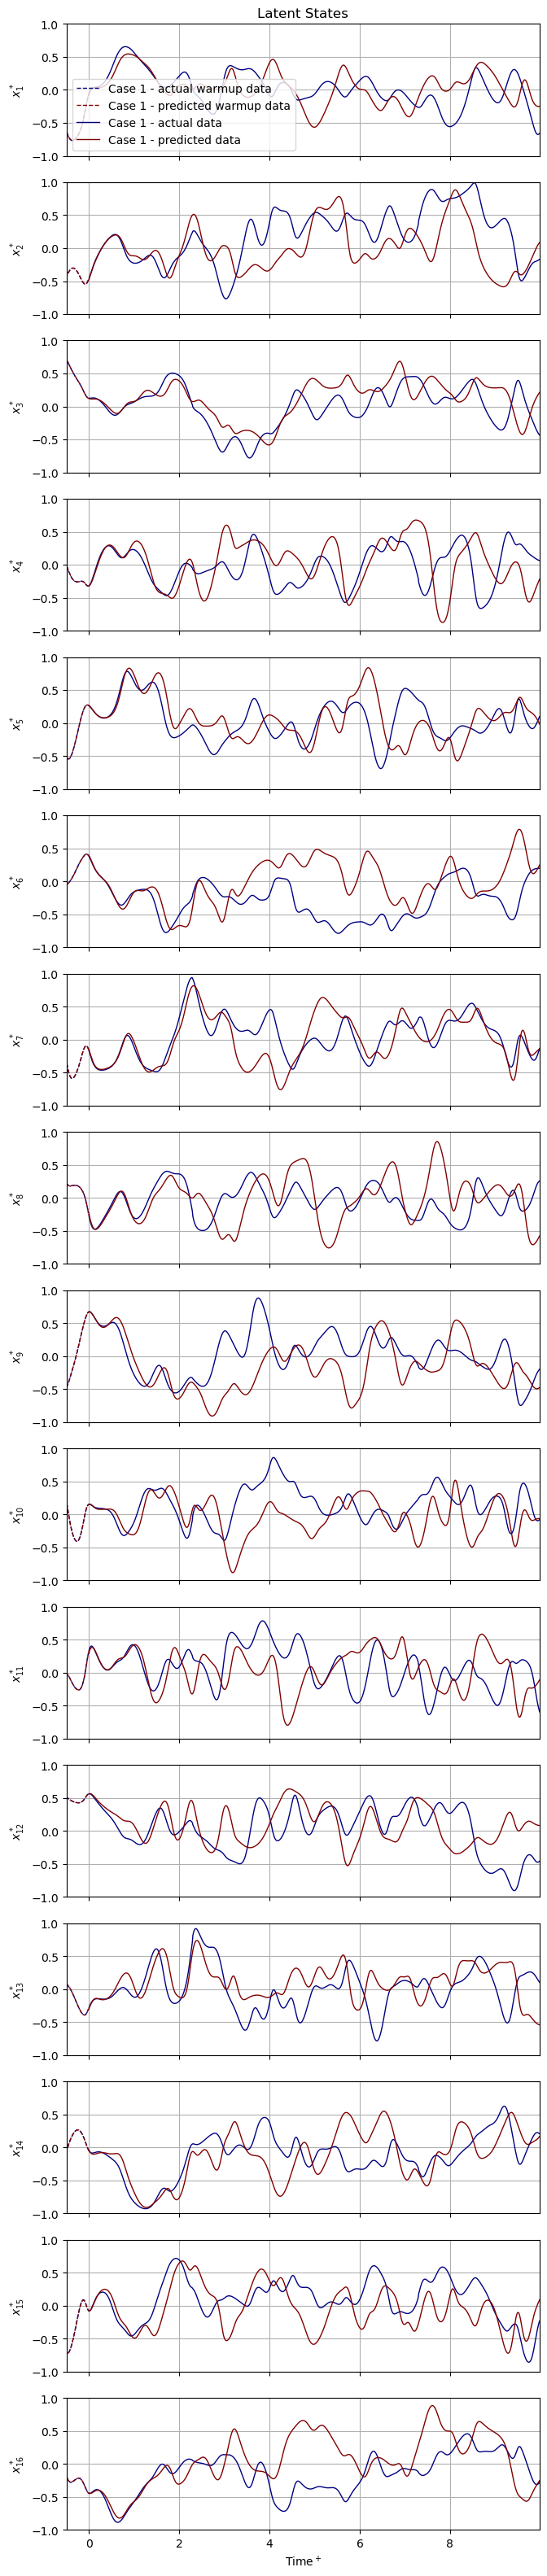

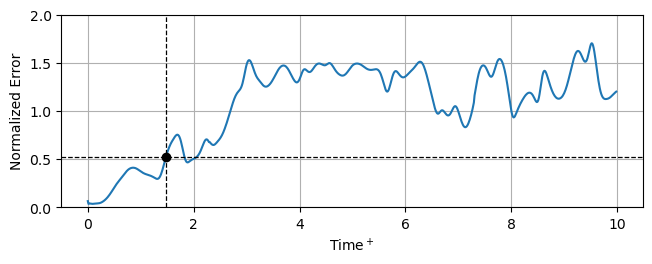

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [55]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.2422307, 1.3950738, 1.2039583, 1.047003 , 1.2421795, 1.3959076,
        1.329816 , 1.4594018, 1.340986 , 1.1908286, 1.3315825, 0.9741959,
        1.2907901, 1.007638 , 1.2783028, 1.3394172], dtype=float32)>]

In [56]:
if use_trainable_weights_with_reslayers == True:
    for i in range(rnn_net.num_skip_connections):
        print('reslayer_factor_{} : {}'.format(i, rnn_net.reslayer_factor[i]))

reslayer_factor_0 : <tf.Variable 'reslayer_weight_0:0' shape=() dtype=float32, numpy=1.0277797>
reslayer_factor_1 : <tf.Variable 'reslayer_weight_1:0' shape=() dtype=float32, numpy=1.0500455>
